# Imports

In [1]:
from src.carga_dados import carregar_dados

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

# Data Loader

In [2]:
dataset = 'dataset/post_pandemic_remote_work_health_impact_2025.csv'
df = carregar_dados(dataset)

In [3]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Exploratory data analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3157 entries, 0 to 3156
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Survey_Date              3157 non-null   object
 1   Age                      3157 non-null   int64 
 2   Gender                   3157 non-null   object
 3   Region                   3157 non-null   object
 4   Industry                 3157 non-null   object
 5   Job_Role                 3157 non-null   object
 6   Work_Arrangement         3157 non-null   object
 7   Hours_Per_Week           3157 non-null   int64 
 8   Mental_Health_Status     2358 non-null   object
 9   Burnout_Level            3157 non-null   object
 10  Work_Life_Balance_Score  3157 non-null   int64 
 11  Physical_Health_Issues   2877 non-null   object
 12  Social_Isolation_Score   3157 non-null   int64 
 13  Salary_Range             3157 non-null   object
dtypes: int64(4), object(10)
memory usage: 34

In [5]:
df.isnull().sum()

Survey_Date                  0
Age                          0
Gender                       0
Region                       0
Industry                     0
Job_Role                     0
Work_Arrangement             0
Hours_Per_Week               0
Mental_Health_Status       799
Burnout_Level                0
Work_Life_Balance_Score      0
Physical_Health_Issues     280
Social_Isolation_Score       0
Salary_Range                 0
dtype: int64

In [6]:
df['Region'].unique()

array(['Asia', 'Africa', 'Europe', 'South America', 'Oceania',
       'North America'], dtype=object)

In [7]:
df['Industry'].unique()

array(['Professional Services', 'Education', 'Manufacturing',
       'Customer Service', 'Technology', 'Finance', 'Retail',
       'Healthcare', 'Marketing'], dtype=object)

In [8]:
df['Job_Role'].unique()

array(['Data Analyst', 'Business Analyst', 'DevOps Engineer',
       'IT Support', 'Technical Writer', 'Software Engineer',
       'HR Manager', 'Project Manager', 'Data Scientist', 'UX Designer',
       'Social Media Manager', 'Digital Marketing Specialist',
       'Account Manager', 'Research Scientist', 'Sales Representative',
       'Operations Manager', 'Customer Service Manager',
       'Product Manager', 'Quality Assurance', 'Executive Assistant',
       'Financial Analyst', 'Marketing Specialist', 'Consultant',
       'Content Writer'], dtype=object)

In [9]:
df['Work_Arrangement'].unique()

array(['Onsite', 'Hybrid', 'Remote'], dtype=object)

In [10]:
df['Burnout_Level'].unique()

array(['High', 'Medium', 'Low'], dtype=object)

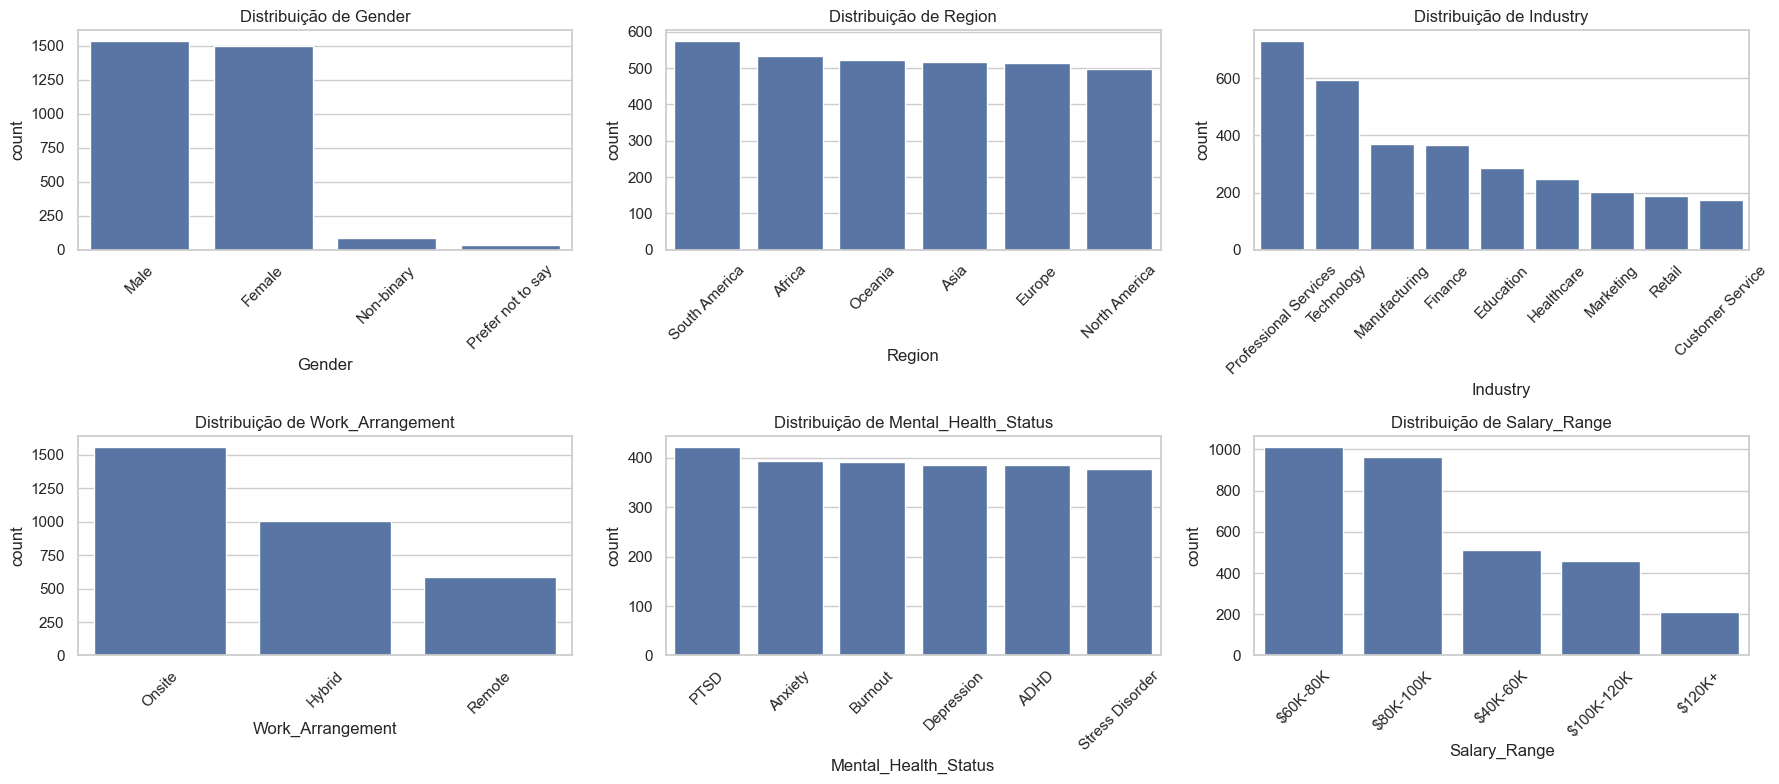

In [11]:
category = ['Gender', 'Region', 'Industry',
               'Work_Arrangement', 'Mental_Health_Status', 
             'Salary_Range']

n_cols = 3
n_rows = (len(category) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(category):
    if col in df.columns and df[col].notnull().any():
        sns.countplot(data=df, x=col, order=df[col].value_counts().index, ax=axes[i])
        axes[i].set_title(f'Distribuição de {col}')
        axes[i].tick_params(axis='x', rotation=45)
    else:
        axes[i].set_visible(False)

for j in range(len(category), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [12]:
print(df['Age'].dtype)
print(df['Hours_Per_Week'].dtype)
print(df['Work_Life_Balance_Score'].dtype)
print(df['Burnout_Level'].dtype)
print(df['Social_Isolation_Score'].dtype)


int64
int64
int64
object
int64


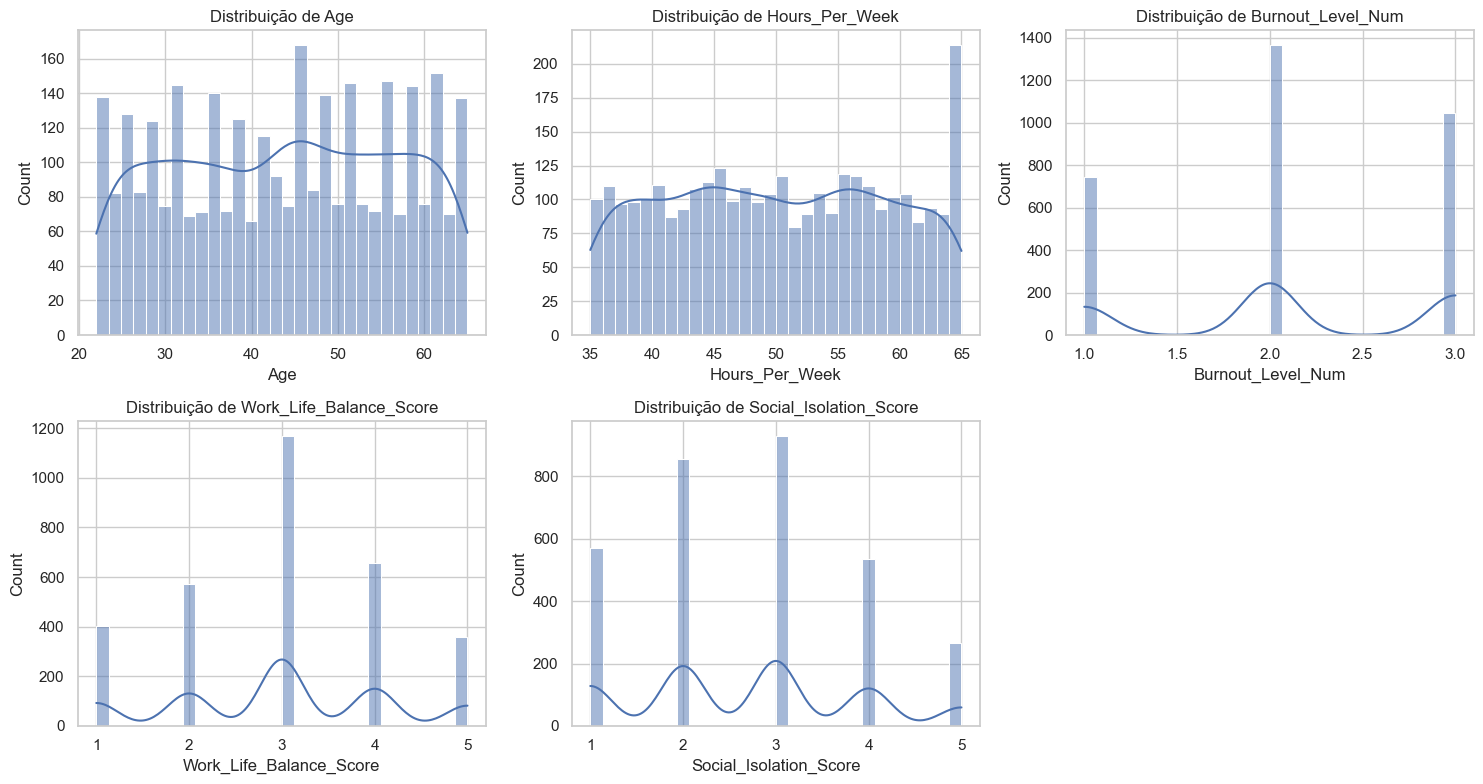

In [13]:
map_burnout = {'Low': 1, 'Medium': 2, 'High': 3}
df['Burnout_Level_Num'] = df['Burnout_Level'].map(map_burnout)

numeric = ['Age', 'Hours_Per_Week', 'Burnout_Level_Num', 
             'Work_Life_Balance_Score', 'Social_Isolation_Score']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten() 

for i, col in enumerate(numeric):
    if col in df.columns and df[col].notnull().any():
        sns.histplot(data=df, x=col, kde=True, bins=30, ax=axes[i])
        axes[i].set_title(f'Distribuição de {col}')
    else:
        axes[i].set_visible(False)

for j in range(len(numeric), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [14]:
df['Burnout_Level'] = pd.to_numeric(df['Burnout_Level'], errors='coerce')
print(df['Burnout_Level'].isnull().sum())

print(df.loc[df['Burnout_Level'].isnull(), 'Burnout_Level'])


3157
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
3152   NaN
3153   NaN
3154   NaN
3155   NaN
3156   NaN
Name: Burnout_Level, Length: 3157, dtype: float64


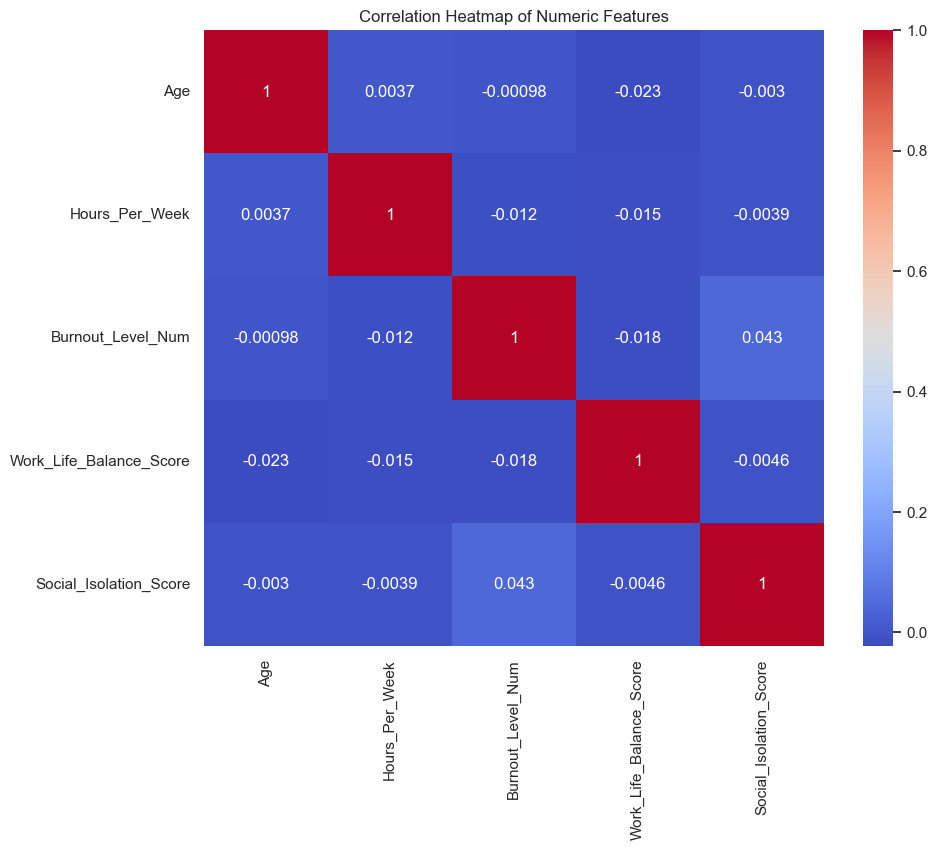

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

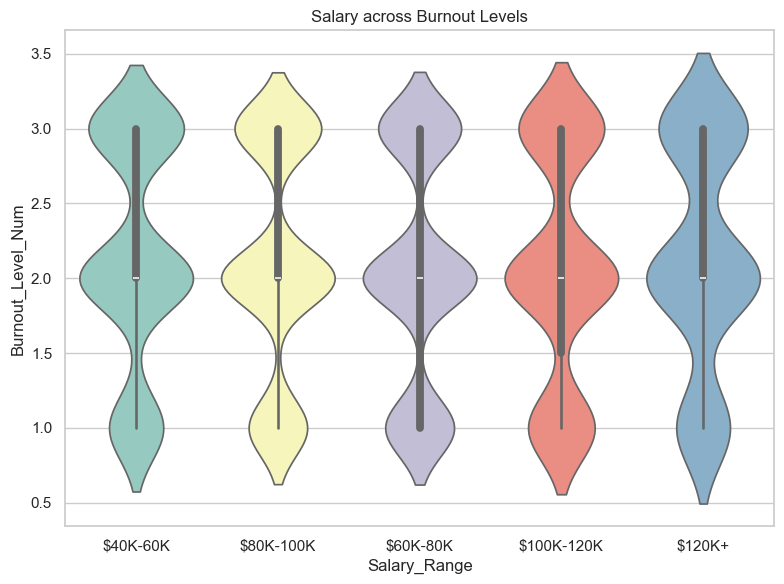

In [16]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=df, x='Salary_Range', y='Burnout_Level_Num', palette='Set3')
plt.title('Salary across Burnout Levels')
plt.tight_layout()
plt.show()

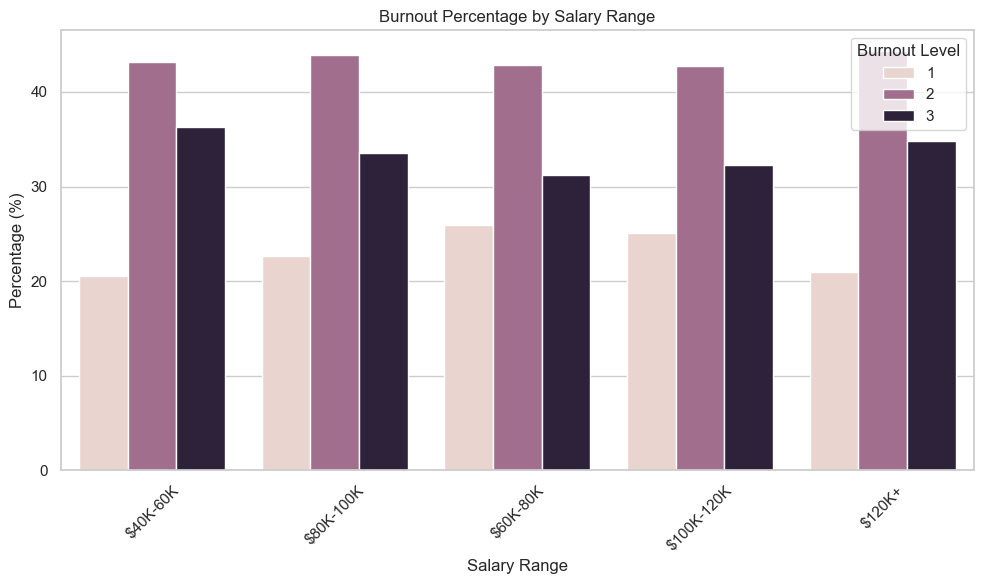

In [17]:
# percentage frequency table
df_percent = (
    df
    .groupby(['Salary_Range', 'Burnout_Level_Num'])
    .size()
    .reset_index(name='count')
)

# Total track
total_salary = df['Salary_Range'].value_counts().rename_axis('Salary_Range').reset_index(name='total')
df_percent = df_percent.merge(total_salary, on='Salary_Range')
df_percent['percent'] = (df_percent['count'] / df_percent['total']) * 100

salary_order = df['Salary_Range'].dropna().unique()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_percent, x='Salary_Range', y='percent', hue='Burnout_Level_Num', order=salary_order)
plt.title('Burnout Percentage by Salary Range')
plt.ylabel('Percentage (%)')
plt.xlabel('Salary Range')
plt.legend(title='Burnout Level')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Clustering

In [18]:
cols_cluster = ['Age', 'Hours_Per_Week', 'Work_Life_Balance_Score', 
                'Social_Isolation_Score', 'Burnout_Level_Num']
df_cluster = df[cols_cluster].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

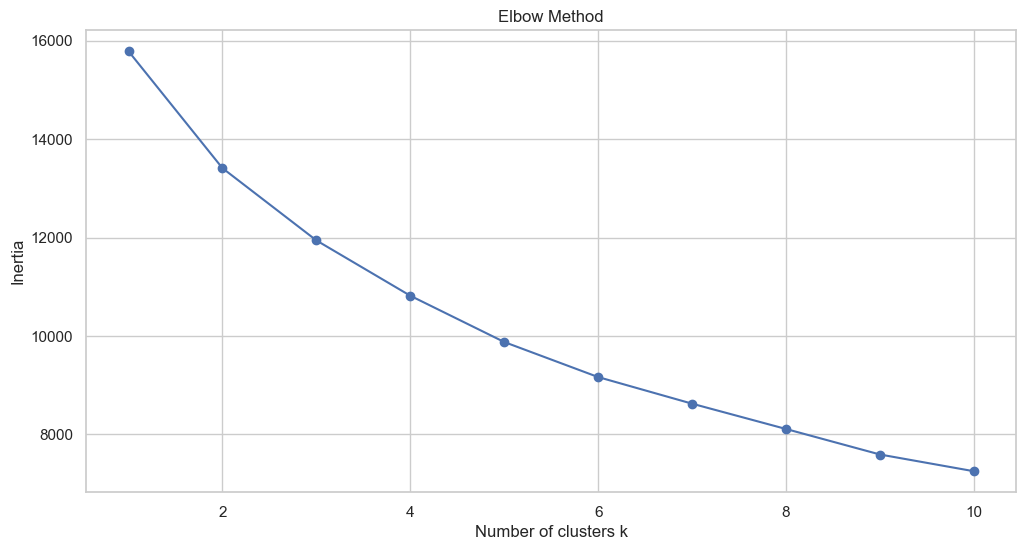

In [19]:
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)  
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


In [20]:
k = 3 
kmeans = KMeans(n_clusters=k, random_state=42)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)


In [21]:
cluster = df_cluster.groupby('cluster').mean()
cluster

,Age,Hours_Per_Week,Work_Life_Balance_Score,Social_Isolation_Score,Burnout_Level_Num
cluster,,,,,
0,44.332027,52.709109,3.000979,2.389814,1.292850
1,31.569668,49.027488,2.964929,2.886256,2.476777
2,55.035153,48.112858,3.023127,2.825162,2.481036


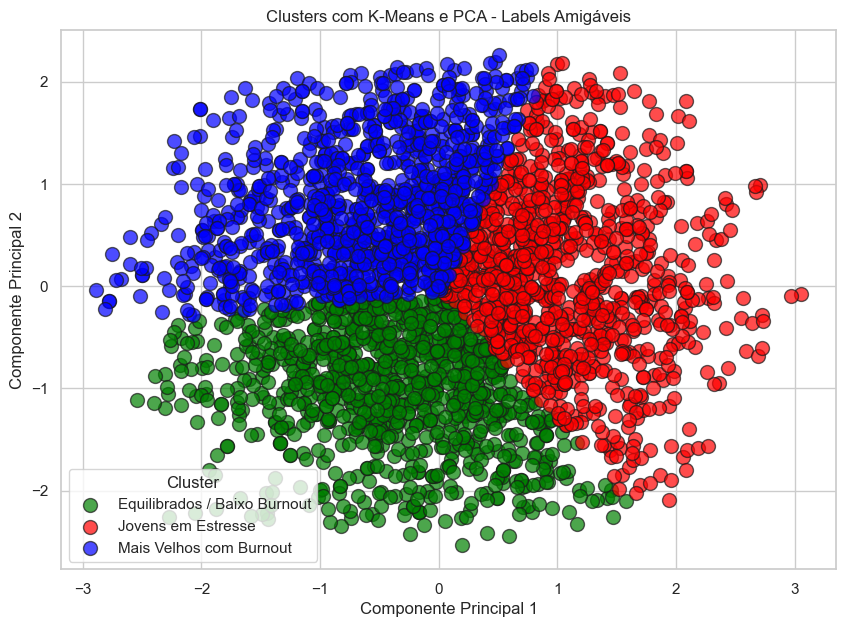

In [22]:
X = df[['Age', 'Hours_Per_Week', 'Burnout_Level_Num','Work_Life_Balance_Score']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

labels_clusters = {
    0: "Equilibrados / Baixo Burnout",
    1: "Jovens em Estresse",
    2: "Mais Velhos com Burnout"
}

cluster_names = np.array([labels_clusters[c] for c in clusters])

colors = {
    "Equilibrados / Baixo Burnout": 'green',
    "Jovens em Estresse": 'red',
    "Mais Velhos com Burnout": 'blue'
}

plt.figure(figsize=(10, 7))

for cluster_label in np.unique(cluster_names):

    idx = cluster_names == cluster_label
    plt.scatter(
        X_pca[idx, 0], X_pca[idx, 1],
        c=colors[cluster_label],
        label=cluster_label,
        s=100,
        alpha=0.7,
        edgecolors='k'
    )

plt.title('Clusters com K-Means e PCA - Labels Amigáveis')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [23]:
df_cluster.groupby('cluster').mean()

,Age,Hours_Per_Week,Work_Life_Balance_Score,Social_Isolation_Score,Burnout_Level_Num
cluster,,,,,
0,44.332027,52.709109,3.000979,2.389814,1.292850
1,31.569668,49.027488,2.964929,2.886256,2.476777
2,55.035153,48.112858,3.023127,2.825162,2.481036


In [24]:
df_cluster.groupby('cluster').agg(['mean', 'std', 'count'])

Age                  Hours_Per_Week                  \
              mean        std count           mean       std count   
cluster                                                              
0        44.332027  11.058155  1021      52.709109  8.723228  1021   
1        31.569668   6.211533  1055      49.027488  8.858159  1055   
2        55.035153   6.525354  1081      48.112858  8.455999  1081   

        Work_Life_Balance_Score                 Social_Isolation_Score  \
                           mean       std count                   mean   
cluster                                                                  
0                      3.000979  1.201714  1021               2.389814   
1                      2.964929  1.121509  1055               2.886256   
2                      3.023127  1.166834  1081               2.825162   

                        Burnout_Level_Num                  
              std count              mean       std count  
cluster                                                    
0        1.104738  1021          1.292850  0.455293  1021  
1        1.197860  1055          2.476777  0.529205  1055  
2        1.198748  1081          2.481036  0.512674  1081